# Proyecto 2 - Machine Learning

In [4]:
# Instalar
%pip install pyts
%pip install h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import h5py
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from queue import PriorityQueue

## Cargar Datos

In [6]:
def load_h5_to_dataframe(file_path):
    with h5py.File(file_path, "r") as f:

        dataframes = []
        for key in list(f.keys()):

            dataset = np.array(f[key])

            if dataset.ndim > 1:
                num_features = dataset.shape[1]
                columns = [f"{key}_{i}" for i in range(num_features)]
                df = pd.DataFrame(dataset, columns=columns)
            else:
                df = pd.DataFrame(dataset, columns=[key])

            dataframes.append(df)

        combined_df = pd.concat(dataframes, axis=1)
        return combined_df

In [7]:
train_path = 'train.h5'
test_path = 'test.h5'

train_data = load_h5_to_dataframe(train_path)
test_data = load_h5_to_dataframe(test_path)

## Split

In [8]:
X = train_data.drop(columns=['y'])
Y = train_data['y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=104, test_size=0.30, shuffle=True)

## Modelos

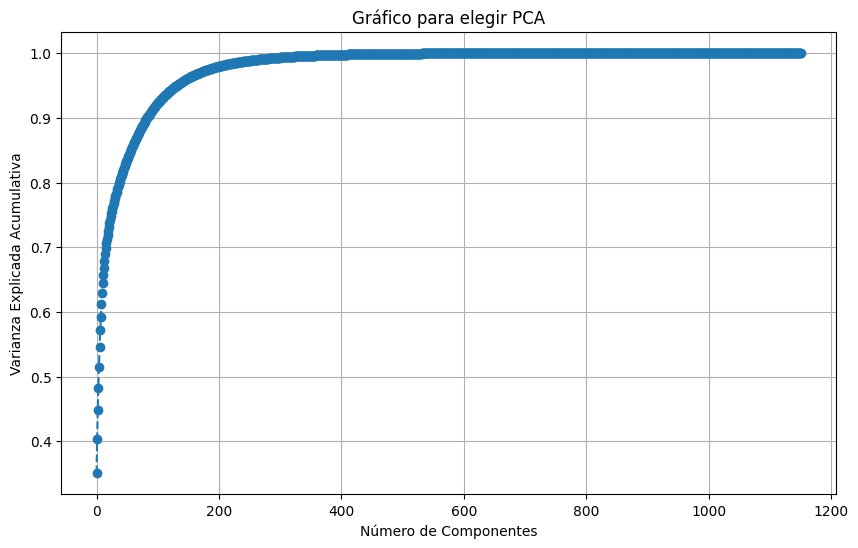

Número de componentes elegido: 132


In [23]:
from sklearn.decomposition import PCA

# Buscamos el número de componentes para el cual tengamos un 0.95 de varianza
pca = PCA().fit(X_train)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1

plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulativa')
plt.title('Gráfico para elegir PCA')
plt.grid(True)
plt.show()

print('Número de componentes elegido:', n_components)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### KNN

In [25]:
def knn(p, X, k):
    k_dist = PriorityQueue(k)
    for i in range(len(X)):
        dist = np.linalg.norm(X[i] - p)
        if not k_dist.full():
            k_dist.put((-dist, i))
        else:
            least_min = k_dist.get()
            if dist < abs(least_min[0]):
                k_dist.put((-dist, i))
            else:
                k_dist.put(least_min)
    return k_dist


def train_knn(X, k, X_train, Y_train):
    Y = list(Y_train)
    y_pred = []
    i=0
    # print(len(X))
    for p in X:
        # print(i)
        i+=1
        k_elem = knn(p, X_train, k)
        y_temp = []
        while not k_elem.empty():
            idx = k_elem.get()[1]
            y_temp.append(Y[idx])
        y_pred.append(max(set(y_temp), key = y_temp.count))
    return y_pred

Encontrar el mejor valor de k:

In [12]:
accuracy = []
for k in range(10):
    print("k:", k)
    y_pred_knn = train_knn(X_test_pca, k+1, X_train_pca, y_train)
    accuracy.append(accuracy_score(y_test, y_pred_knn))

best_k = np.argmax(accuracy) + 1
print('Mejor k: ', best_k)
print(f'Accuracy para k={best_k}:', accuracy[best_k-1])

k: 0
2206
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


Mejor K = 1, 0.9664551223934723

Accuracy: 0.9664551223934723
F1-score: 0.9640647532538993


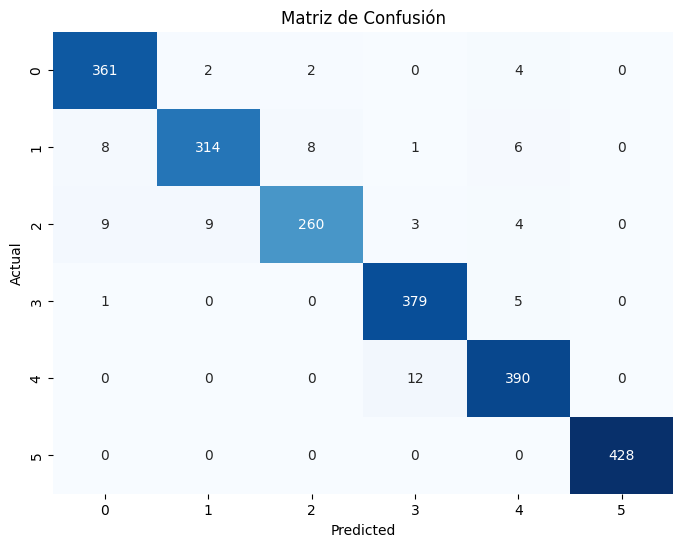

In [28]:
y_pred = train_knn(X_test_pca, 1, X_train_pca, y_train)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1-score: {f1}')

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Dtree

In [14]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# Nodo del Árbol de Decisión
class Nodo:
    def __init__(self, index=None, threshold=None, left=None, right=None, value=None):
        self.index = index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def IsTerminal(self, Y):
        return len(set(Y)) == 1

    def Entropy(self, Y):
        histogram = Counter(Y)
        probabilities = [freq / len(Y) for freq in histogram.values()]
        return -sum(p * np.log2(p) for p in probabilities if p > 0)

    def BestSplit(self, X, Y):
        best_gain = -1
        best_feature, best_threshold = None, None
        num_samples, num_features = X.shape

        current_entropy = self.Entropy(Y)

        for feature_index in range(num_features):
            thresholds = set(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold
                left_y, right_y = Y[left_mask], Y[right_mask]
                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                left_entropy = self.Entropy(left_y)
                right_entropy = self.Entropy(right_y)
                p_left = len(left_y) / len(Y)
                gain = current_entropy - (p_left * left_entropy + (1 - p_left) * right_entropy)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold


class DT:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.m_Root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def create_DT(self, X, Y, depth=0):
        self.m_Root = self._build_tree(X, Y, depth)

    def _build_tree(self, X, Y, depth):
        node = Nodo()
        if node.IsTerminal(Y) or depth == self.max_depth or len(Y) < self.min_samples_split:
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        best_feature, best_threshold = self.Find_Best_Split(X, Y)
        if best_feature is None:
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = X[:, best_feature] > best_threshold
        left_X, right_X = X[left_mask], X[right_mask]
        left_Y, right_Y = Y[left_mask], Y[right_mask]

        if len(left_Y) < self.min_samples_leaf or len(right_Y) < self.min_samples_leaf:
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        node.index = best_feature
        node.threshold = best_threshold
        node.left = self._build_tree(left_X, left_Y, depth + 1)
        node.right = self._build_tree(right_X, right_Y, depth + 1)

        return node

    def Find_Best_Split(self, X, Y):
        node = Nodo()
        return node.BestSplit(X, Y)

    def _predict_one(self, x):
        node = self.m_Root
        while node.value is None:
            if x[node.index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        return np.array([self._predict_one(x) for x in X])

# Función para predecir
def dt_predict(X, Y, X_new):
    print('Building Model')
    tree_model = DT()

    # Entrenar el modelo
    print('Training Model')
    tree_model.create_DT(X, Y)

    print('Making Predictions')
    # Realizar las predicciones
    Y_pred = np.array([tree_model._predict_one(x) for x in X_new])

    return Y_pred


Búsqueda de hiperparámetros

In [17]:
best_f1 = 0
best_params = {}

for max_depth in range(5, 10):
    print("MAX DEPTH:", max_depth)
    for min_samples_split in range(2, 7, 2):
        print("MIN SAMPLES SPLIT:", min_samples_split)
        for min_samples_leaf in range(2, 7, 2):
            print("MIN SAMPLES LEAF:", min_samples_leaf)
            tree_model = DT(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            tree_model.create_DT(X_train_pca, y_train)
            y_pred = tree_model.predict(X_test_pca)
            
            # Specify average='macro' or 'weighted' depending on the use case
            f1 = f1_score(y_test, y_pred, average='macro')

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    "max_depth": max_depth,
                    "min_samples_split": min_samples_split,
                    "min_samples_leaf": min_samples_leaf
                }

print("Mejores parámetros:", best_params)
print("Mejor F1 Score:", best_f1)


MAX DEPTH: 5
MIN SAMPLES SPLIT: 2
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MIN SAMPLES SPLIT: 4
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MIN SAMPLES SPLIT: 6
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MAX DEPTH: 6
MIN SAMPLES SPLIT: 2
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MIN SAMPLES SPLIT: 4
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MIN SAMPLES SPLIT: 6
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MAX DEPTH: 7
MIN SAMPLES SPLIT: 2
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MIN SAMPLES SPLIT: 4
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MIN SAMPLES SPLIT: 6
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MAX DEPTH: 8
MIN SAMPLES SPLIT: 2
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MIN SAMPLES SPLIT: 4
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES LEAF: 6
MIN SAMPLES SPLIT: 6
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF

9 2 2
Mejor F1 Score: 0.8277264154813856

Accuracy: 0.8404351767905711
F1-score: 0.9640647532538993


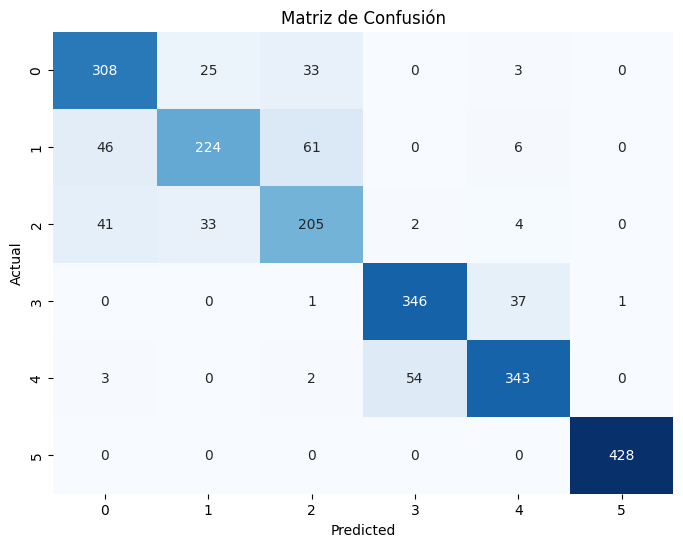

In [29]:
# Crear y entrenar el modelo
tree_model = DT(max_depth=9, min_samples_split=2, min_samples_leaf=2)
tree_model.create_DT(X_train_pca, y_train)

# Hacer predicciones
Y_pred = tree_model.predict(X_test_pca)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, Y_pred)

accuracy = accuracy_score(y_test, Y_pred)
print(f'Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1-score: {f1}')

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
